In [1]:
import argparse
import yaml
from tqdm import tqdm
import sys

import pickle

import jax
import jax.numpy as jnp
import optax   

import math
import numpy as np
import matplotlib.pyplot as plt

from helpers.data import get_pdf_toy, read_in_data_JAX

# Params and Initialization

### @RADHA, IMPORTANT CHANGE

I made it so mstar is the lowest power of alpha that can appear in either g_star or g_mn.

If mstar = 1, then the 0th row of both matrices correspond to alpha^1 terms.

If mstar = 0, then the 0th row of both matrices correspond to alpha^0 terms. 

Look at `utils.distribution_utils.build_q_mstar`to see how this works. 

In [ ]:
# TODO: Replace this with Radha's YAML files
mstar = 1
m = 2
n = 9

lr = 0.001
weight_decay = 0.01
epochs = 5000
batch_size = 320
seed = 42
freeze_previous_order = True # NEW

name = f"thrust_m{m}_n{n}"
init_from = f"thrust_m{m-1}_n{n}"

# Seed stuff
np.random.seed(seed)
jax_key = jax.random.PRNGKey(seed)


# Initialize params
params = {
    "g_star" : -np.zeros((m+1 - mstar, n+1)),
    "g_coeffs" : -np.zeros((m+1 - mstar, n+1)),
    "thetas" : np.zeros((m+1 - mstar,)),
}



# # For flavor, slightly smarter inits
signs = (-1) * np.power(-1, np.arange(n + 1) % 2)
params["g_star"][0,1] = -1
params["thetas"][0] = 0.5
if m == 2:
    params["thetas"][1] = 0.1

# Decent sign initialization
for mi in range(m+1-mstar):
    params["g_star"][mi] *= signs
    params["g_coeffs"][mi] *= signs






No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
# Init from previous file:

if init_from:

    with open(f"output_JAX/{init_from}_params.pkl", "rb") as f:
        init_params = pickle.load(f)

    g_coeffs_init = init_params["g_coeffs"]
    g_star_init = init_params["g_star"]
    thetas_init = init_params["thetas"]

    init_m, init_n = g_coeffs_init.shape

    params["g_coeffs"][:init_m, :init_n] = g_coeffs_init
    params["g_star"][:init_m, :init_n] = g_star_init
    params["thetas"][:init_m] = thetas_init


# Save the original params for the purpose of freezing
original_params = params.copy()

# Compilation 

Notation:
Functions with the postfix `vmap` are vmapped in `t` but NOT `alpha`. So you can run it for a batch of `ts` but with a SCALAR `alpha`

Functions with the postfix `vmap2` are vmapped in `t` and `alpha` seperately. So you can run it for a batch of N `ts` and a batch of `M` alphas, and the result will be an (M, N) array.

In [4]:
from utils.function_utils import polynomial, taylor_expand_in_alpha
from utils.distribution_utils import build_q_mstar, log_q, f
from rikabplotlib.plot_utils import newplot

q = build_q_mstar(mstar)

# compile
q_vmap = jax.vmap(q, in_axes=(0,None,None,None, None))
f_vmap = jax.vmap(f, in_axes=(0,None,None,None, None))
polynomial_vmap = jax.vmap(polynomial, in_axes=(0,None,None,None))


# Taylor Expansions
q0_vmap = jax.vmap(taylor_expand_in_alpha(q, 0), in_axes=(0,None,None,None,None))
q1_vmap = jax.vmap(taylor_expand_in_alpha(q, 1), in_axes=(0,None,None,None,None))
q2_vmap = jax.vmap(taylor_expand_in_alpha(q, 2), in_axes=(0,None,None,None,None))
q3_vmap = jax.vmap(taylor_expand_in_alpha(q, 3), in_axes=(0,None,None,None,None))
# ... Add more if necessary, can loop if we really have to

qm_vmap = [q0_vmap, q1_vmap, q2_vmap, q3_vmap]

# ##### Second vmap over alpha #####
q_vmap2 = jax.vmap(q_vmap, in_axes = (None, 0, None, None, None))
qm_vmap2 = []
for qi in qm_vmap:
    qi_vmap2 = jax.vmap(qi, in_axes = (None, 0, None, None, None))
    qm_vmap2.append(qi_vmap2)



# Select the Taylor Expansion Function
CHOSEN_Q_VMAP = qm_vmap[m]
CHOSEN_Q_VMAP2 = qm_vmap2[m]


# Data Setup

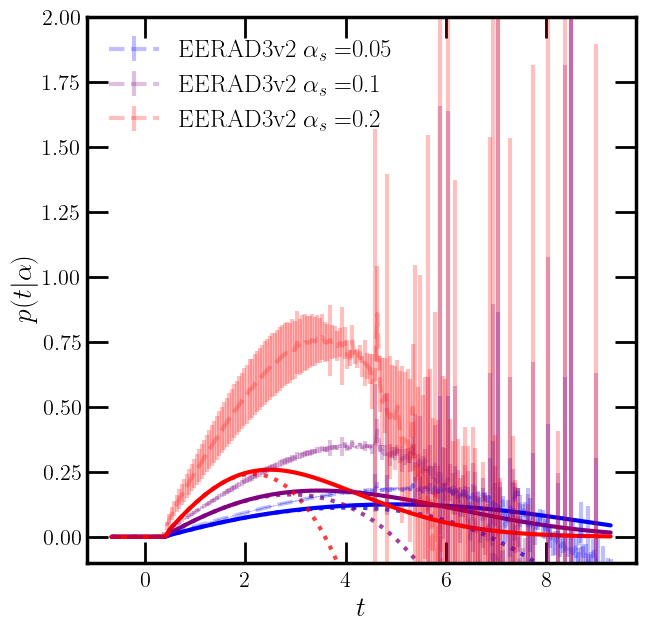

In [5]:
data_dict, t_bins, t_bin_centers = read_in_data_JAX("thrust", m)

alpha_keys = np.array(list(data_dict.keys()))
alpha_keys_float = list(data_dict.keys())

t_min = jnp.min(t_bins)
t_max = jnp.max(t_bins)


# Keys of interest
keys = np.array([0.05, 0.1, 0.2])

# Find the keys in the list closest to these values (to deal with floating point errors)
for (k, key) in enumerate(keys):

    closest_key = alpha_keys_float[np.argmin(np.abs(key - alpha_keys))]
    keys[k] = closest_key


# Make an array of ys and yerrs so we dont have to keep the dictionary around
ys = []
yerrs = []
for key in alpha_keys_float:
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]

    # clamp yerr by its nonzero minimum

    min_y_err = np.min(yerr[yerr > 0])
    yerr = np.clip(yerr, a_min=min_y_err.item(), a_max=None)
    
    ys.append(y)
    yerrs.append(yerr)

ys = jnp.array(ys)
yerrs = jnp.array(yerrs)


# Make a plot of the data 
colors = ["blue", "purple", "red"]
fig, ax = newplot("full")
q_vals = q_vmap2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])
q_taylor_vals = CHOSEN_Q_VMAP2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

plt.ylim(-0.1, 2)
# plt.xscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$p(t | \alpha)$")
plt.legend(loc = "upper left")



# Loss and Training

In [6]:
# Set up the loss as a function of the parameters

loss_epsilon = 0

# Weighted MSE
@jax.jit
def loss_function(params):

    y_preds = jnp.nan_to_num(CHOSEN_Q_VMAP2(t_bin_centers, alpha_keys, params["g_star"], params["g_coeffs"], params["thetas"]))
    mean_errors = jnp.mean(yerrs)
    y_errs_rescaled = yerrs / mean_errors

    return jnp.mean((y_preds - ys)**2 /(y_errs_rescaled**2 + loss_epsilon)) / 2


print("Initial Loss: ", loss_function(params))


Initial Loss:  309.0513


### Projector

Function to make sure that the polynomial's final coefficients always have the correct sign, and if freezing is on, keep the original parameters

In [7]:
def project(params):

    # Get the signs right
    g_star = params["g_star"]
    g_coeffs = params["g_coeffs"]
    thetas = params["thetas"]

    g_star = g_star.at[:, -1].set(-jnp.abs(g_star[:, -1]))
    g_coeffs = g_coeffs.at[:, -1].set(-jnp.abs(g_coeffs[:, -1]))


    # Restore the original parameters if frozen
    if freeze_previous_order:

        g_coeffs_init = original_params["g_coeffs"]
        g_star_init = original_params["g_star"]
        thetas_init = original_params["thetas"]

        g_star = g_star.at[:-1].set(g_star_init[:-1])
        g_coeffs = g_coeffs.at[:-1].set(g_coeffs_init[:-1])
        thetas = thetas.at[:-1].set(thetas_init[:-1])



    params["g_star"] = g_star
    params["g_coeffs"] = g_coeffs
    params["thetas"] = thetas


    return params

### BOGO Initializer

In [8]:
bogo_epochs = 5000

best_loss = loss_function(params)
best_params = params.copy()

factorials = np.ones_like(params["g_star"])
for mi in range(params["g_star"].shape[0]):
    for ni in range(params["g_star"].shape[1]):
        factorials[mi, ni] = 1 / math.factorial(mi + mstar) / math.factorial(ni)

counter = 0
for epoch in range(bogo_epochs):

    scale = (bogo_epochs - epoch) / bogo_epochs

    loss = loss_function(params)
    if loss < best_loss:
        best_loss = loss
        best_params = params.copy()
        counter += 1

    else:

        # Initialize params
        jax_key, subkey1, subkey2, subkey3 = jax.random.split(jax_key, 4)

        g_star = np.random.normal(loc = best_params["g_star"], size = params["g_star"].shape, scale = factorials / (np.sqrt(counter) + 1) * scale / 10) 
        g_coeffs = np.random.normal(loc = best_params["g_coeffs"], size = params["g_coeffs"].shape, scale = factorials / (np.sqrt(counter) + 1) * scale / 10)  

        # Choose signs nicely
        for ni in range(g_star.shape[1]):

            if n % 2 == 0:
                g_star[:,n] = np.abs(g_star[:,n])
                g_coeffs[:,n] = np.abs(g_coeffs[:,n])
            else:
                g_star[:,n] = -np.abs(g_star[:,n])
                g_coeffs[:,n] = -np.abs(g_coeffs[:,n])


        thetas = params["thetas"]
        thetas = np.random.normal(loc = best_params["thetas"], scale = 1 / (np.sqrt(counter) + 1) * scale / 10) 

        params = {
            "g_star" : jnp.array(g_star),
            "g_coeffs" : jnp.array(g_coeffs),
            "thetas" : jnp.array(thetas),
        }

        # Make sure params are physical
        params = project(params)

    print("BOGO Epoch", epoch, "Loss =", loss, "Best Loss =", best_loss, "Counter =", counter)

params = best_params.copy()
print(params)



BOGO Epoch 0 Loss = 309.0513 Best Loss = 309.0513 Counter = 0
BOGO Epoch 1 Loss = 1790.7279 Best Loss = 309.0513 Counter = 0
BOGO Epoch 2 Loss = 3077.073 Best Loss = 309.0513 Counter = 0
BOGO Epoch 3 Loss = 304.44125 Best Loss = 304.44125 Counter = 1
BOGO Epoch 4 Loss = 304.44125 Best Loss = 304.44125 Counter = 1
BOGO Epoch 5 Loss = 304.55753 Best Loss = 304.44125 Counter = 1
BOGO Epoch 6 Loss = 309.15765 Best Loss = 304.44125 Counter = 1
BOGO Epoch 7 Loss = 304.00357 Best Loss = 304.00357 Counter = 2
BOGO Epoch 8 Loss = 304.00357 Best Loss = 304.00357 Counter = 2
BOGO Epoch 9 Loss = 300.4283 Best Loss = 300.4283 Counter = 3
BOGO Epoch 10 Loss = 300.4283 Best Loss = 300.4283 Counter = 3
BOGO Epoch 11 Loss = 301.42664 Best Loss = 300.4283 Counter = 3
BOGO Epoch 12 Loss = 297.64496 Best Loss = 297.64496 Counter = 4
BOGO Epoch 13 Loss = 297.64496 Best Loss = 297.64496 Counter = 4
BOGO Epoch 14 Loss = 296.93146 Best Loss = 296.93146 Counter = 5
BOGO Epoch 15 Loss = 296.93146 Best Loss = 29

### Real Training

Note due to compilation, epoch 1 should take a long time, but every subsequent epoch should be faster

In [9]:
params = best_params.copy()


  0%|          | 0/5000 [00:00<?, ?it/s]

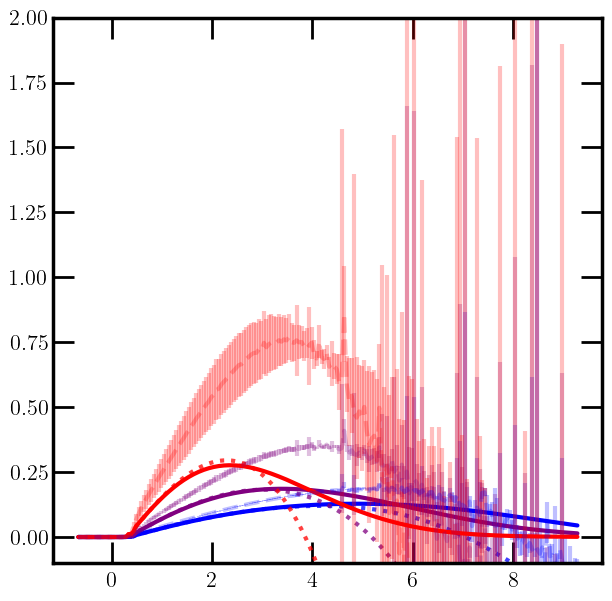

 195.5449:   2%|▏         | 99/5000 [00:19<05:52, 13.91it/s]  

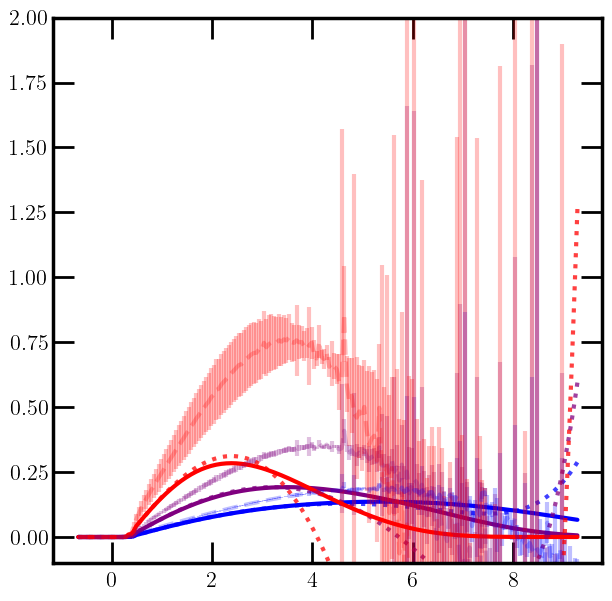

 166.7223:   4%|▍         | 199/5000 [00:28<06:47, 11.79it/s]

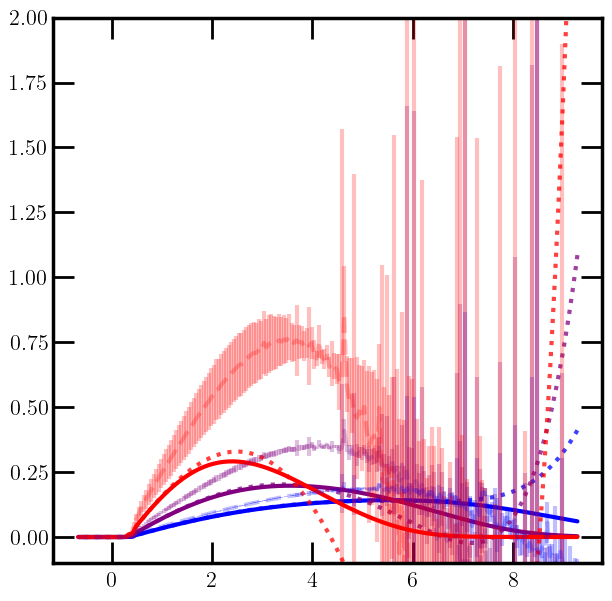

 143.5531:   6%|▌         | 299/5000 [00:39<07:27, 10.50it/s]

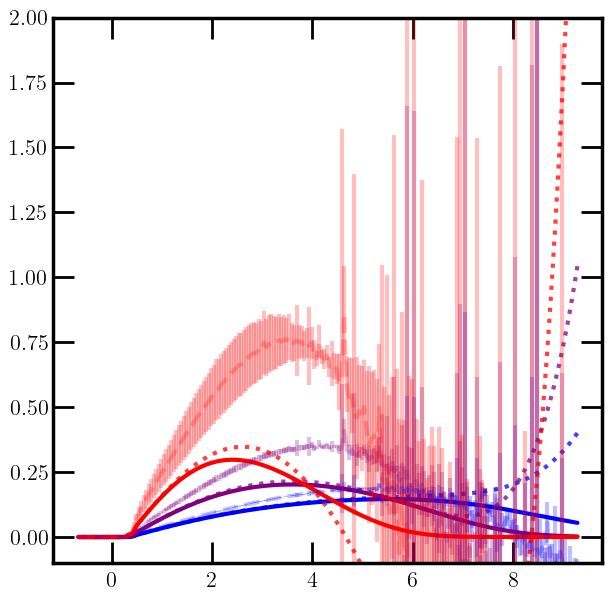

 124.0246:   8%|▊         | 400/5000 [00:48<06:29, 11.81it/s]

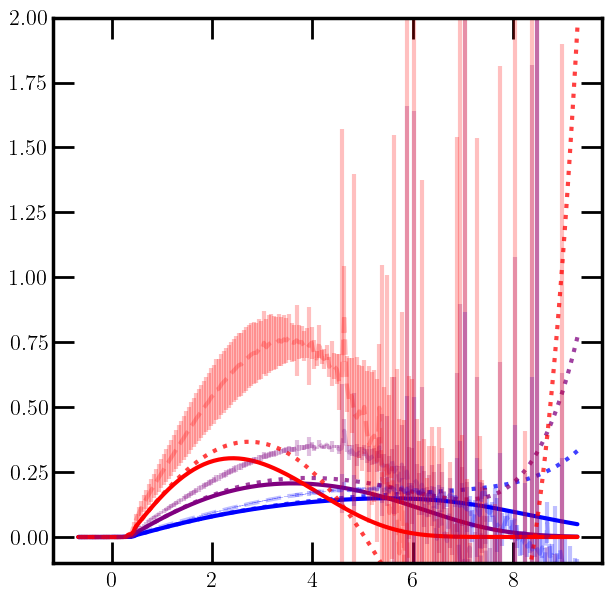

 107.7043:  10%|█         | 500/5000 [00:58<06:38, 11.28it/s]

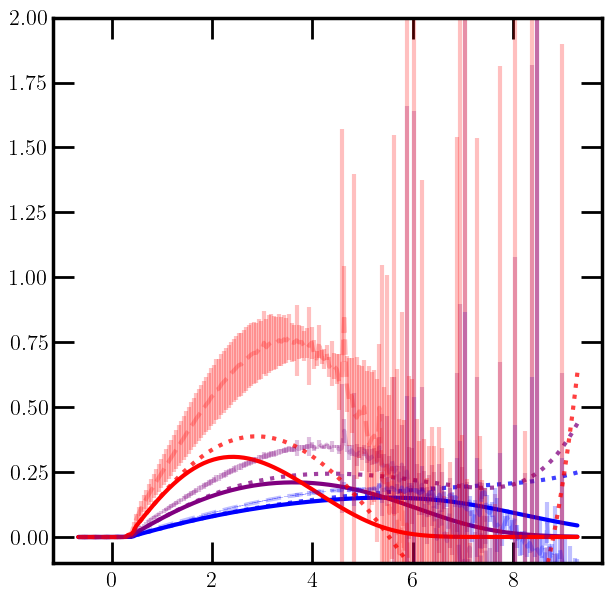

 94.2248:  12%|█▏        | 600/5000 [01:07<05:24, 13.57it/s] 

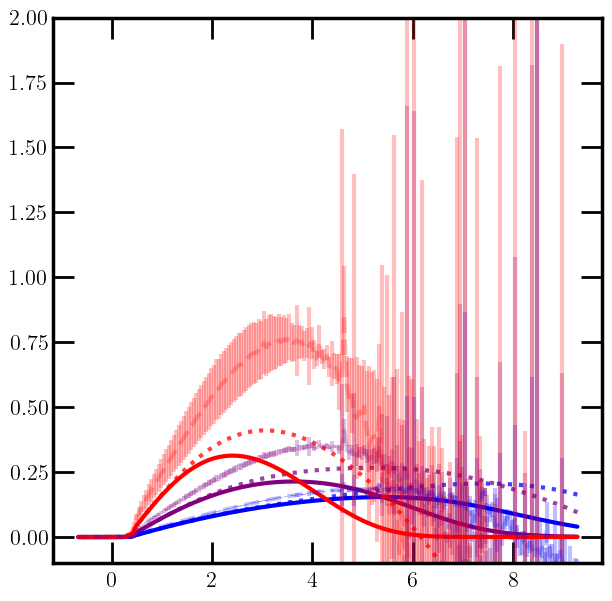

 83.2310:  14%|█▍        | 700/5000 [01:17<05:59, 11.97it/s]

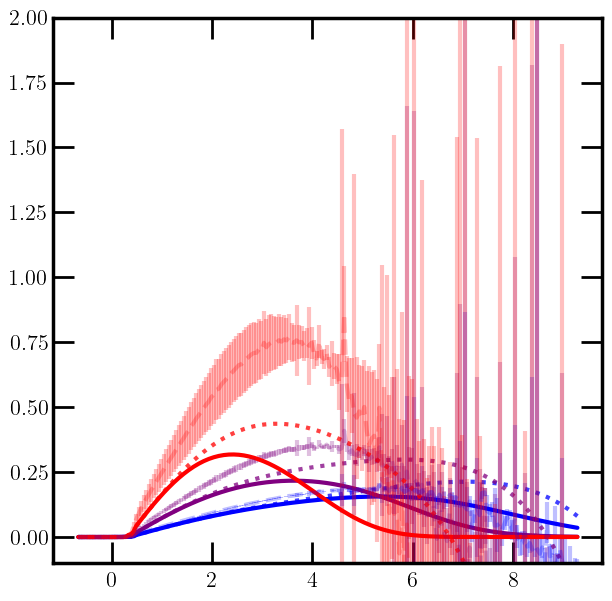

 74.3806:  16%|█▌        | 800/5000 [01:26<04:53, 14.32it/s]

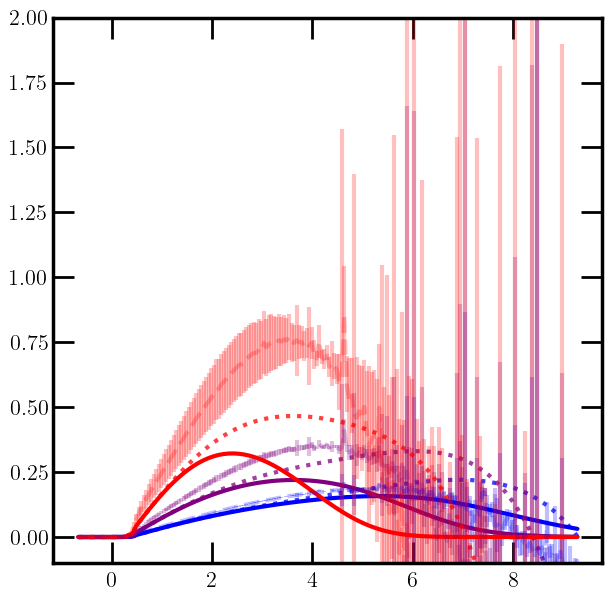

 67.3483:  18%|█▊        | 900/5000 [01:35<05:16, 12.97it/s]

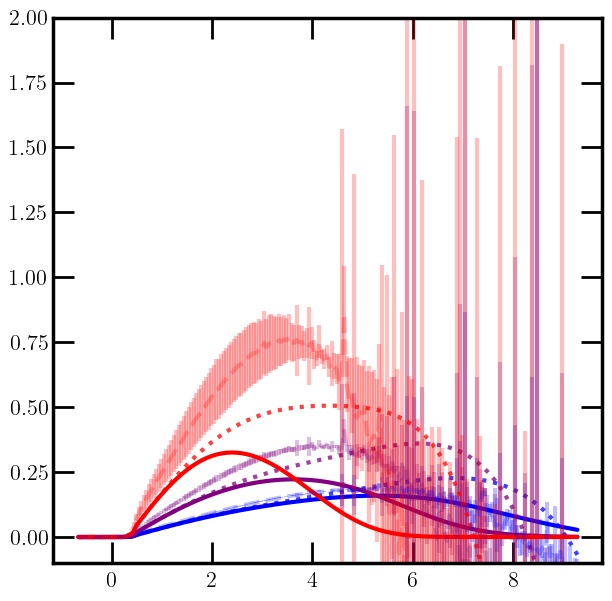

 61.8300:  20%|██        | 1000/5000 [01:45<06:35, 10.12it/s]

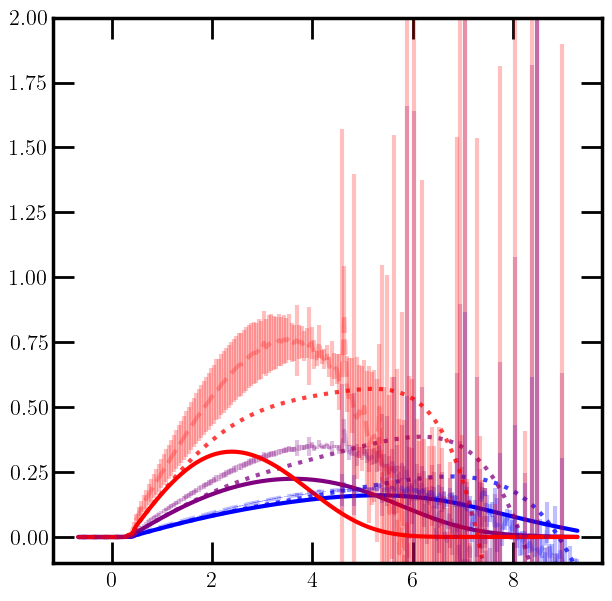

 57.5467:  22%|██▏       | 1099/5000 [01:55<04:26, 14.66it/s]

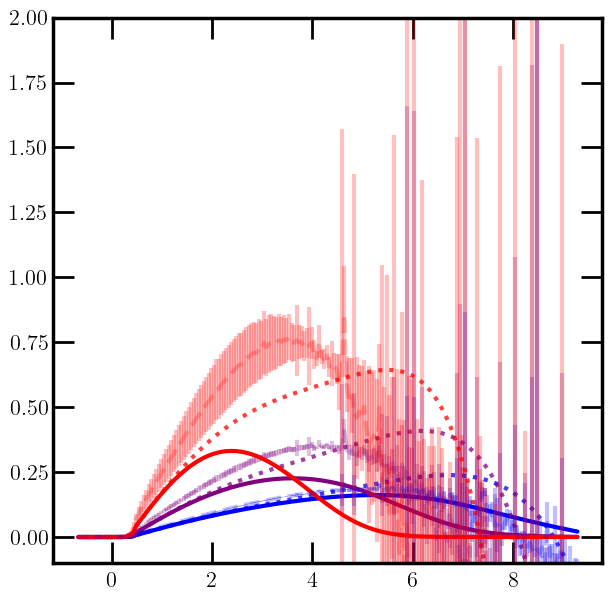

 54.2480:  24%|██▍       | 1199/5000 [02:04<05:00, 12.64it/s]

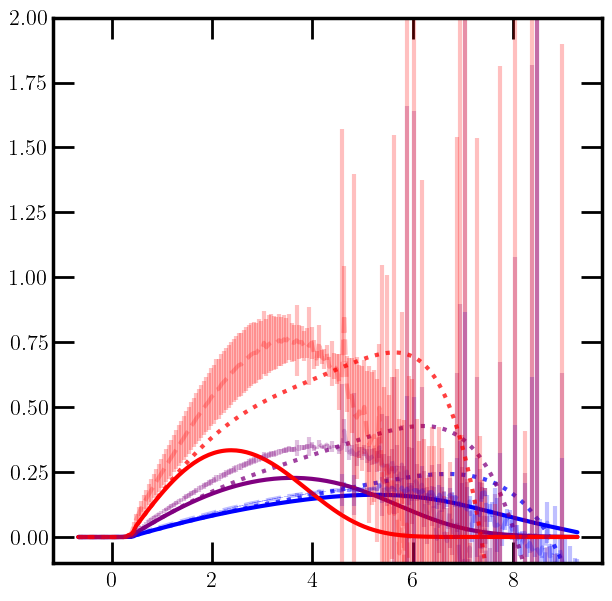

 51.7151:  26%|██▌       | 1299/5000 [02:14<04:51, 12.71it/s]

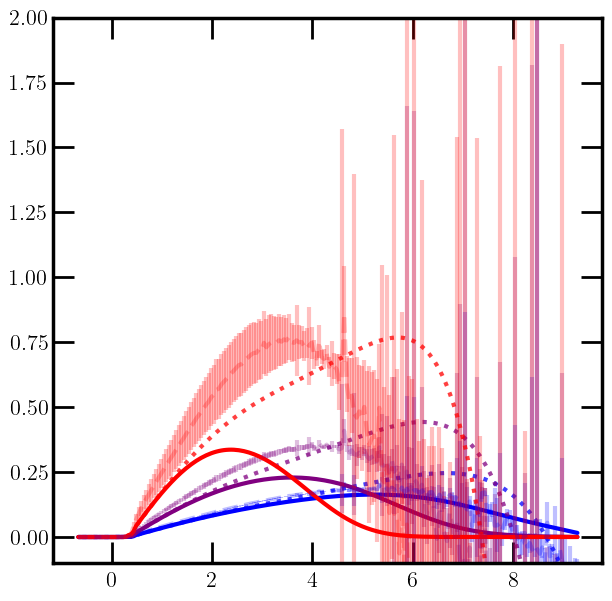

 49.7618:  28%|██▊       | 1399/5000 [02:24<05:53, 10.19it/s]

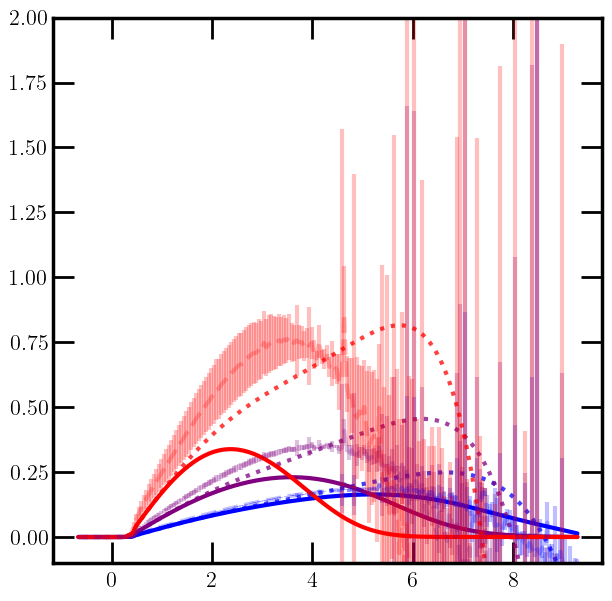

 49.5255:  28%|██▊       | 1413/5000 [02:26<06:34,  9.09it/s]

In [ ]:
# Initialize Optimizer
opt = optax.adamw(lr  , weight_decay= weight_decay)
opt_state = opt.init(params)

# Initialize logs
losses = []
params_log = []
params_log.append(params)
g_coeffs_log = [params["g_coeffs"]]
g_star_log = [params["g_star"]]
thetas_log = [params["thetas"]]

# @jax.jit
def train_step(epoch, params, opt_state, random_key):
    
    # Boilerplate, in case we need random numbers
    key, subkey = jax.random.split(random_key)

    # Get the gradients
    loss, grad_loss = jax.value_and_grad(loss_function)(params)

    # Jax Grad Descent stuff
    updates, opt_state = opt.update(grad_loss, opt_state, params=params)
    params = optax.apply_updates(params, updates)

    

    # Save the random key for the seed for the next epoch
    return params, opt_state, loss, subkey

# Loop
epochs_tqdm = tqdm(range(epochs))
for epoch in epochs_tqdm:



    if epoch % 100 == 0:
        fig, ax = newplot("full")
        q_vals = q_vmap2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])
        q_taylor_vals = CHOSEN_Q_VMAP2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])

        for (k, key) in enumerate(keys):
            y, yerr = data_dict[key]
            y = y[:,0]
            yerr = yerr[:,0]
            plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
            plt.plot(t_bin_centers, q_vals[k], color = colors[k])
            plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")


        plt.ylim(-0.1, 2e0)
        plt.show()


    # Train Step
    params, opt_state, loss, jax_key = train_step(epoch, params, opt_state, jax_key)


    # Project the params to make them physical
    params = project(params)
    # print(params)

    losses.append(loss)
    g_star_log.append(params['g_star'])
    g_coeffs_log.append(params['g_coeffs'])
    thetas_log.append(params['thetas'])
    params_log.append(params)


    epochs_tqdm.set_description(f"{losses[-1].item() : .4f}")
    # print(g_coeffs_log[-1])
    # print(g_star_log[-1])
    # print(thetas_log[-1])



In [ ]:

with open(f"output_JAX/{name}_params.pkl", "wb") as f:
    pickle.dump(params, f)


/tmp/ipykernel_135046/1215073456.py:7: RuntimeWarning: divide by zero encountered in log
  g_coeffs_log = np.log(g_coeffs_log)
/tmp/ipykernel_135046/1215073456.py:7: RuntimeWarning: invalid value encountered in log
  g_coeffs_log = np.log(g_coeffs_log)


Text(0.5, 0, 'epochs')

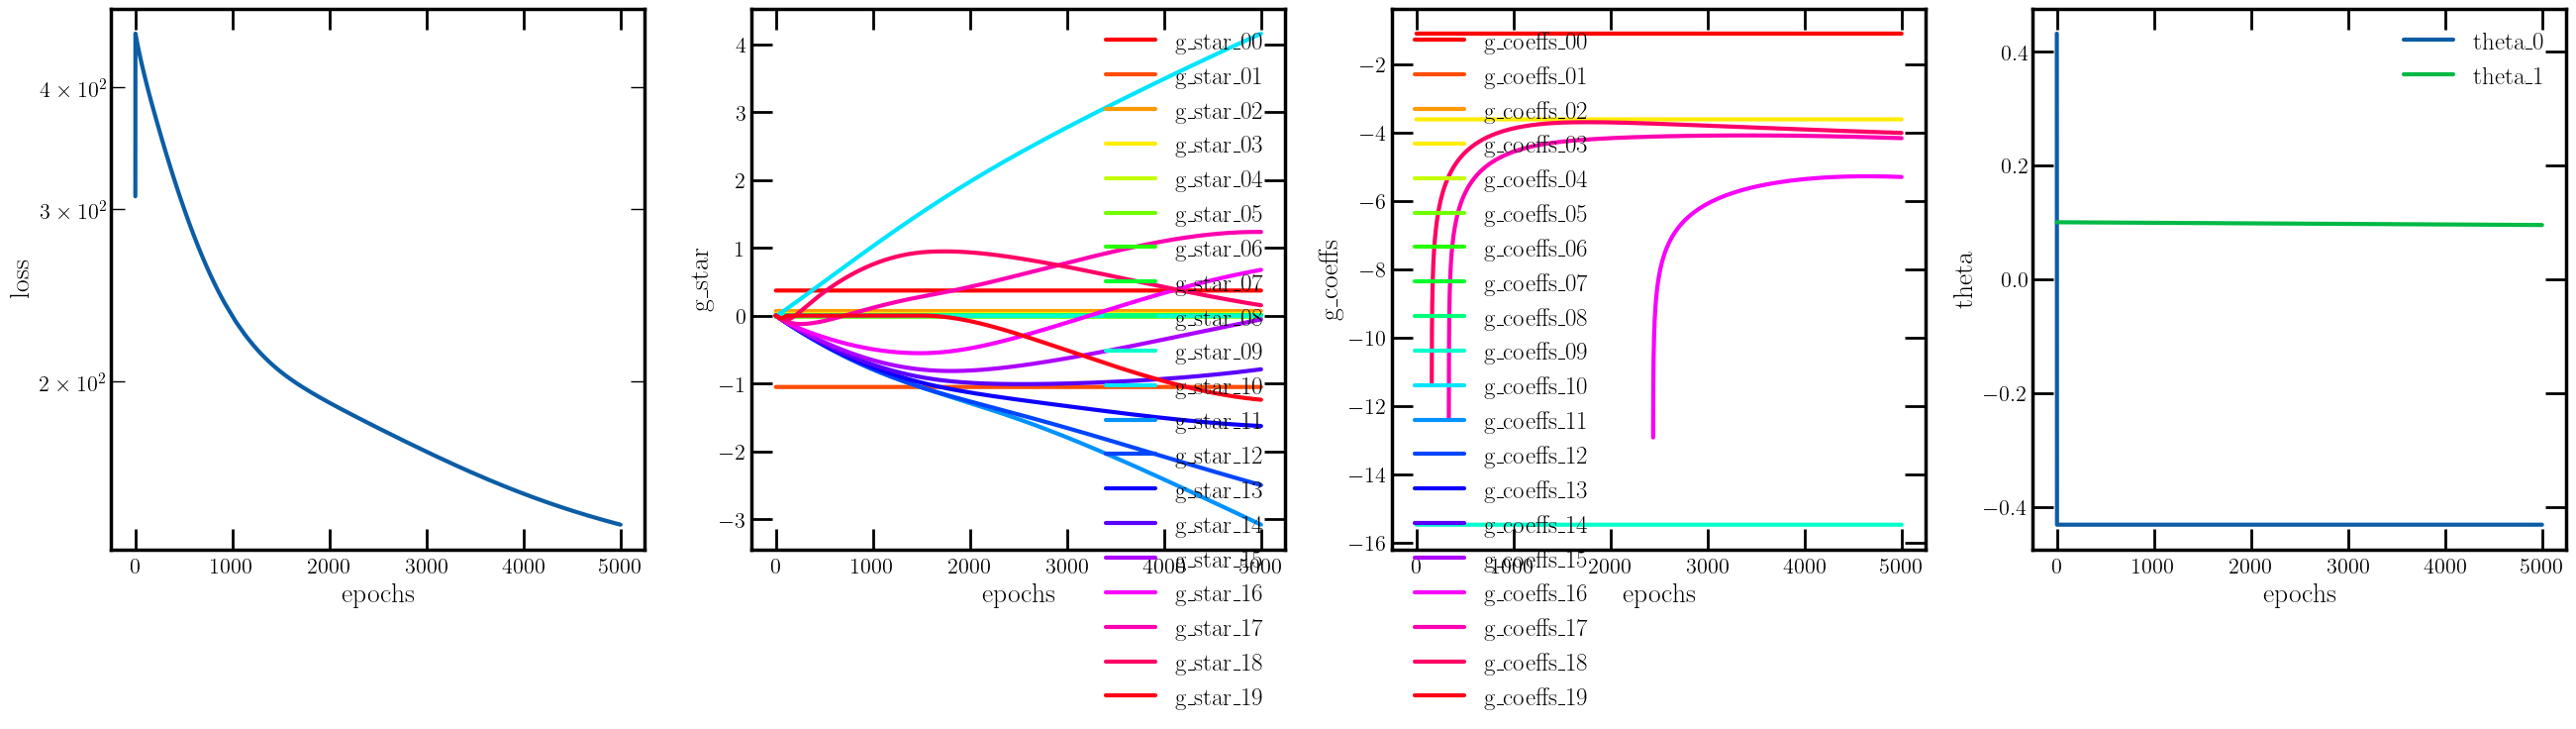

In [ ]:
from matplotlib.pyplot import cm

fig, ax = newplot("full", width = 8 * 4, subplot_array=(1, 4))

losses = np.array(losses)
g_star_log = np.array(g_star_log)
g_coeffs_log = np.log(g_coeffs_log)
thetas_log = np.array(thetas_log)


color = iter(
    cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2]))
)


ax[0].plot(losses)
ax[0].set_yscale("log")

for mi in range(g_star_log.shape[1]):

    ax[3].plot(thetas_log[:,mi], label = f"theta_{mi}")

    for ni in range(g_star_log.shape[2]):

        c = next(color)

        ax[1].plot(g_star_log[:,mi,ni], color = c, label = f"g_star_{mi}{ni}")
        ax[2].plot(g_coeffs_log[:,mi,ni], color = c, label = f"g_coeffs_{mi}{ni}")

ax[0].set_ylabel("loss")
ax[0].set_xlabel("epochs")

ax[1].legend()
ax[1].set_ylabel("g_star")
ax[1].set_xlabel("epochs")

ax[2].legend()
ax[2].set_ylabel("g_coeffs")
ax[2].set_xlabel("epochs")

ax[3].legend()
ax[3].set_ylabel("theta")
ax[3].set_xlabel("epochs")

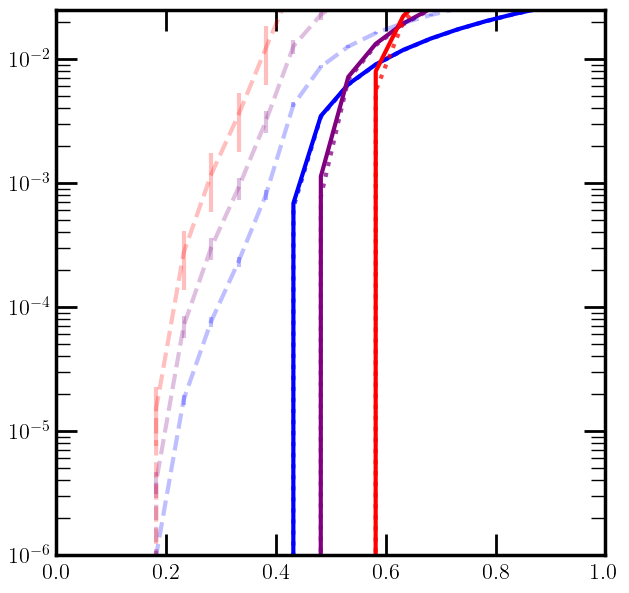

{'g_coeffs': Array([[ 3.3256245e-01, -7.3381454e-02, -4.8795044e-02,  2.7028367e-02,
        -4.5974455e-03, -2.0069470e-04, -9.1678853e-04, -1.2357554e-03,
        -1.5178472e-03,  1.9049122e-07],
       [-2.0367488e-02, -4.5206301e-02, -5.9316173e-02, -5.5332936e-02,
        -3.6911123e-02, -1.3915852e-02,  5.0025494e-03,  1.5579121e-02,
         1.8168293e-02, -1.0805184e-02]], dtype=float32), 'g_star': Array([[ 3.69362950e-01, -1.05151343e+00,  6.73692375e-02,
         2.56164558e-02, -1.79194082e-02, -1.28091015e-02,
        -4.35774346e-05,  7.32796034e-03,  8.64529517e-03,
        -7.10308971e-03],
       [ 4.15492773e+00, -3.08036399e+00, -2.49684381e+00,
        -1.62603998e+00, -7.90779531e-01, -5.57018183e-02,
         6.74033165e-01,  1.23250353e+00,  1.52356923e-01,
        -1.23930728e+00]], dtype=float32), 'thetas': Array([-0.43153995,  0.09512278], dtype=float32)}


In [ ]:
fig, ax = newplot("full")

params = params_log[-1]

# params = {'g_coeffs': jnp.array([[-1.4129587e+00, -8.3932149e-01, -3.6408892e-01,  2.1668930e-01,
#          9.2633456e-02, -8.7050162e-02, -1.0447601e-01, -1.3033234e-02,
#          1.0823050e-01, -2.7595865e-02],
#        [ 1.9706091e-02,  1.0751380e-01,  7.2292695e-03,  7.2420542e-03,
#          3.4468577e-03, -6.2232531e-05,  1.3756469e-05,  5.0528266e-05,
#          3.6526422e-04, -5.9835085e-05]]), 'g_star': jnp.array([[ 3.6294520e-01, -1.0979660e+00,  1.9972968e-01, -8.7971516e-02,
#         -3.1348750e-02,  4.8306610e-02,  7.9979207e-03, -3.1092776e-02,
#          1.3078115e-02, -1.0615622e-04],
#        [-1.5308211e+00, -1.4279670e+00, -6.4494938e-01, -4.9874373e-02,
#          3.3021158e-01,  1.8047714e-01,  3.7153810e-02,  1.6338695e-02,
#          7.4233182e-02, -8.4546432e-02]]), 'thetas': jnp.array([0.44273797, 0.53100968])}

q_vals = q_vmap2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])
q_taylor_vals = CHOSEN_Q_VMAP2(t_bin_centers, keys, params["g_star"], params["g_coeffs"], params["thetas"])

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

plt.xlim(0, 1)
plt.ylim(0.000001, 0.025)
# plt.xscale("log")
plt.yscale("log")
plt.show()

print(params)


309.0513
453.51706
452.96832


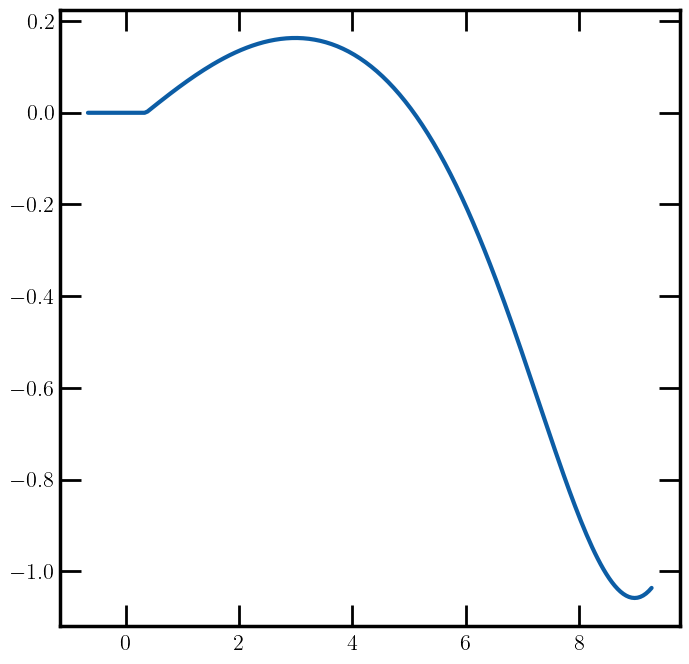

In [ ]:
print(loss_function(params_log[0]))
print(loss_function(params_log[1]))
print(loss_function(params_log[2]))

y_preds = CHOSEN_Q_VMAP2(t_bin_centers, keys, params_log[1]["g_star"], params_log[1]["g_coeffs"], params_log[1]["thetas"])
y_preds = jnp.nan_to_num(y_preds)

y_preds = CHOSEN_Q_VMAP2(t_bin_centers, keys, params_log[1]["g_star"], params_log[1]["g_coeffs"], params_log[1]["thetas"])
plt.plot(t_bin_centers, y_preds[1])